## E- COMMERCE RECOMMENDER SYSTEM

## Data Wrangling and EDA

The objective of this notebook is to inspect, explore and clean the raw dataset in order to come up with a processed data frame that will feed into the modelling step

## import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

## Loading and reading data

Data source: https://www.kaggle.com/arashnic/marketing-bias-dataset

In [2]:
raw_data = pd.read_csv('/Users/judith/Data_science_projects/Springboard_AssignmentsJY/capstone_three/data/raw/df_modcloth.csv')

## Inspecting data

In [3]:
raw_data.head()

,item_id,user_id,rating,timestamp,size,fit,user_attr,model_attr,category,brand,year,split
0,7443,Alex,4,2010-01-21 08:00:00+00:00,NaN,NaN,Small,Small,Dresses,NaN,2012,0
1,7443,carolyn.agan,3,2010-01-27 08:00:00+00:00,NaN,NaN,NaN,Small,Dresses,NaN,2012,0
2,7443,Robyn,4,2010-01-29 08:00:00+00:00,NaN,NaN,Small,Small,Dresses,NaN,2012,0
3,7443,De,4,2010-02-13 08:00:00+00:00,NaN,NaN,NaN,Small,Dresses,NaN,2012,0
4,7443,tasha,4,2010-02-18 08:00:00+00:00,NaN,NaN,Small,Small,Dresses,NaN,2012,0


In [4]:
raw_data.describe()

,item_id,rating,size,year,split
count,99893.000000,99893.000000,78133.000000,99893.000000,99893.000000
mean,83944.091208,4.209594,3.217322,2015.476450,0.358564
std,43558.135979,1.080633,1.885934,1.970262,0.720993
min,6454.000000,1.000000,0.000000,2010.000000,0.000000
25%,48629.000000,4.000000,2.000000,2014.000000,0.000000
50%,77878.000000,5.000000,3.000000,2016.000000,0.000000
75%,120126.000000,5.000000,4.000000,2017.000000,0.000000
max,155950.000000,5.000000,8.000000,2019.000000,2.000000


In [5]:
raw_data.info()  # checking data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99893 entries, 0 to 99892
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   item_id     99893 non-null  int64  
 1   user_id     99892 non-null  object 
 2   rating      99893 non-null  int64  
 3   timestamp   99893 non-null  object 
 4   size        78133 non-null  float64
 5   fit         81387 non-null  object 
 6   user_attr   91526 non-null  object 
 7   model_attr  99893 non-null  object 
 8   category    99893 non-null  object 
 9   brand       25913 non-null  object 
 10  year        99893 non-null  int64  
 11  split       99893 non-null  int64  
dtypes: float64(1), int64(4), object(7)
memory usage: 9.1+ MB


### Analysing ratings and users

/Users/judith/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rating', ylabel='Density'>

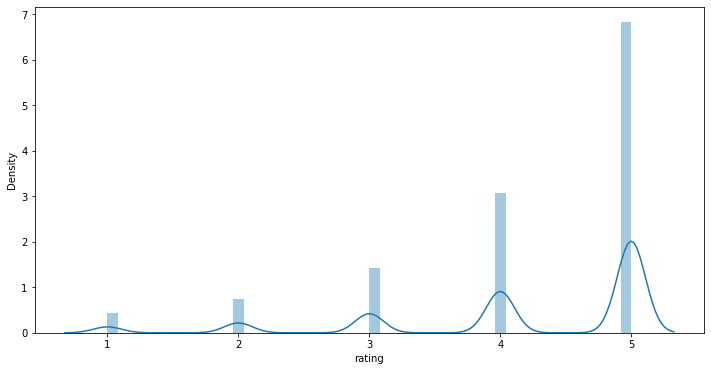

In [6]:
# ratings distribution
plt.figure(figsize = (12,6))
sns.distplot(raw_data.rating)

In [7]:
# Analyzing the distribution of average number of ratings by item
avg_rating = raw_data[['item_id', 'rating']]
mean_rating = avg_rating.groupby('item_id').mean()
mean_rating.sort_values(by = 'rating', ascending = False)

,rating
item_id,
152834,5.000000
153536,5.000000
153196,5.000000
148277,5.000000
153131,5.000000
...,...
152737,1.750000
152888,1.750000
152146,1.333333


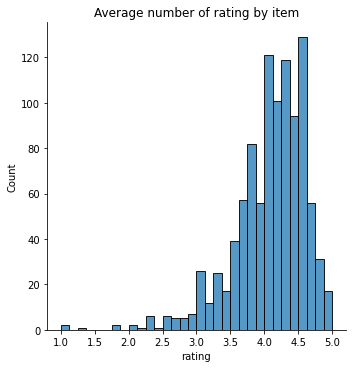

In [8]:
sns.displot(mean_rating.rating)
plt.title('Average number of rating by item')
plt.show()

In [9]:
# Analyzing the distribution of total number of ratings by item
tot_rating = avg_rating.groupby('item_id').count()
tot_rating.sort_values(by = 'rating', ascending = False)

,rating
item_id,
34935,1887
21296,1636
32405,1599
32406,1494
32403,1378
...,...
152835,1
151458,1
153339,1


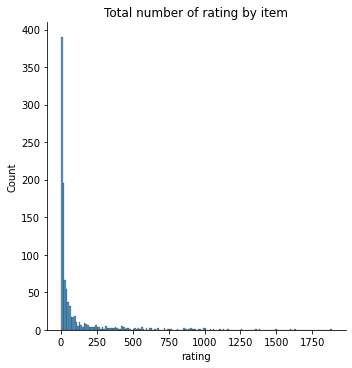

In [10]:
sns.displot(tot_rating.rating)
plt.title('Total number of rating by item')
plt.show()

- Rating distribution is very dense with no gap in data over a scale from 1 to 5
- Distribution of average number of rating per item is right skewed which confirms that there are some 'very popular' items with high frequency of rating while others have much lower number of rating
- The second plot tell us that most items only have few number of ratings

In [11]:
# calculating average number of items purchased by user
users = raw_data['user_id'].nunique()
items = len(np.unique(raw_data.item_id))
print('There are {} users and {} items for a ratio of {} items purchased by user'.format(users, items, users/items))

There are 44783 users and 1020 items for a ratio of 43.904901960784315 items purchased by user


We have far more users than products, this means that we have more data to cover many different types user profiles 

## Checking missing value

In [12]:
raw_data.isnull().sum() # checking quantities of null values

item_id           0
user_id           1
rating            0
timestamp         0
size          21760
fit           18506
user_attr      8367
model_attr        0
category          0
brand         73980
year              0
split             0
dtype: int64

In [13]:
missing = raw_data.isnull().sum()/len(raw_data)   # getting an idea of the proportion of missing data

In [14]:
data_sum= pd.DataFrame({'missing':missing, 'cat': raw_data.dtypes})
data_sum

,missing,cat
item_id,0.000000,int64
user_id,0.000010,object
rating,0.000000,int64
timestamp,0.000000,object
size,0.217833,float64
fit,0.185258,object
user_attr,0.083760,object
model_attr,0.000000,object
category,0.000000,object
brand,0.740592,object


## Checking unique values in each column

In [15]:
# Creating a function to count the number of unique values in each column

def unique(df, cols):
    unique_val = []
    for col in cols:
        unique_val.append(len(df[col].value_counts()))
    return unique_val

In [16]:
unique_val = unique(raw_data, data_sum.index)

In [17]:
data_sum['unique'] = unique_val
data_sum

,missing,cat,unique
item_id,0.000000,int64,1020
user_id,0.000010,object,44783
rating,0.000000,int64,5
timestamp,0.000000,object,14741
size,0.217833,float64,9
fit,0.185258,object,5
user_attr,0.083760,object,2
model_attr,0.000000,object,2
category,0.000000,object,4
brand,0.740592,object,31


In [18]:
# Creating a function to display the unique values for attributes
# this is limited to attributes having less than 10 unique values 
# Doing this allow us to see the different values of categorical data

def unique_short(df, cols):
    for col in cols:
        print(col, df[col].value_counts())

In [19]:
attributes= data_sum.loc[data_sum['unique'] < 10]

In [20]:
unique_short(raw_data, attributes.index)

rating 5    54568
4    24591
3    11360
2     5851
1     3523
Name: rating, dtype: int64
size 2.0    18211
3.0    17752
1.0    15195
5.0     7759
4.0     7388
6.0     6004
7.0     3793
8.0     1948
0.0       83
Name: size, dtype: int64
fit Just right        55287
Slightly large    11114
Slightly small    10771
Very large         2177
Very small         2038
Name: fit, dtype: int64
user_attr Small    73161
Large    18365
Name: user_attr, dtype: int64
model_attr Small&Large    57032
Small          42861
Name: model_attr, dtype: int64
category Tops         34977
Dresses      34160
Bottoms      23625
Outerwear     7131
Name: category, dtype: int64
split 0    78551
2    14476
1     6866
Name: split, dtype: int64


**Summary of cleaning tasks :**
- user_id:  
    - There is 1 missing user_id value and the entire row will need to be removed
- Timestamp
    - We will drop this column as it wont be useful for any of our analysis
- size
    - There are about 22% missing values. We can apply a nearest neighbor strategy to populate these missing values
- fit
    - There are about 18% of missing values. We will apply the same strategy as size for missing values. 

- user_attr
    - there are 8% of missing values. We will apply the same strategy as size for missing values.
    
- model_attr
    - no missing values
    
- category
    - no missing values

- brand
    - There are about 74% of missing values which means this column will be useless. we will simply drop it.
    
Others columns (item_id, rating, year and split) do not have to be processed as already in the right type with no missing values

## Cleaning data

### Dropping unuseful columns and rows

In [21]:
# Dropping the column 'brand' and checking it is effective
data = raw_data.drop(['brand','timestamp'], axis = 1) # we are creating a new dataframe 'data' to keep clean data
data.columns

Index(['item_id', 'user_id', 'rating', 'size', 'fit', 'user_attr',
       'model_attr', 'category', 'year', 'split'],
      dtype='object')

In [22]:
# dropping the row with missing user_id
data.dropna(subset = ['user_id'], inplace = True)

In [23]:
# checking that the change is effective
data.user_id.isnull().value_counts()

False    99892
Name: user_id, dtype: int64

### Populating missing values for categorical data types

We will use KNN Imputer to impute missing categorical data representing features. We chose this method because it doesnt affect the distribution of data. However, it requires 2 prior steps: 1) scale data to reduce the 'noise' and encode categorical values into objects daata need to be in numerical process. We will also scale data to reduce the noise.

In [24]:
# We will first split our data into 2 dataframes to suits the different modelling scenario
ratings = raw_data[['item_id', 'user_id','rating']] # to be used in collaborative filtering recommender
raw_features = data.drop(['item_id', 'user_id','rating', ], axis = 1) # to be used in content based recommender

In [25]:
features = pd.get_dummies(raw_features, drop_first = True)
features.head()

,size,year,split,fit_Slightly large,fit_Slightly small,fit_Very large,fit_Very small,user_attr_Small,model_attr_Small&Large,category_Dresses,category_Outerwear,category_Tops
0,NaN,2012,0,0,0,0,0,1,0,1,0,0
1,NaN,2012,0,0,0,0,0,0,0,1,0,0
2,NaN,2012,0,0,0,0,0,1,0,1,0,0
3,NaN,2012,0,0,0,0,0,0,0,1,0,0
4,NaN,2012,0,0,0,0,0,1,0,1,0,0


In [26]:
features.shape

(99892, 12)

Populating missing values using KNN imputer

In [27]:
# scaling features 
scaler = MinMaxScaler()
scaled_features = pd.DataFrame(scaler.fit_transform(features), columns = features.columns)
scaled_features.head()

,size,year,split,fit_Slightly large,fit_Slightly small,fit_Very large,fit_Very small,user_attr_Small,model_attr_Small&Large,category_Dresses,category_Outerwear,category_Tops
0,NaN,0.222222,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,NaN,0.222222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,NaN,0.222222,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,NaN,0.222222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,NaN,0.222222,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [28]:
# defining a function to imputs categorica columns in the features dataframe
def knn_imputer(df, n):
    imputer = KNNImputer(n_neighbors = n)
    df_trans = imputer.fit_transform(df)
    return df_trans

In [29]:
# implementing the imputer on the scaled features
processed_features = knn_imputer(scaled_features, 5)

In [30]:
processed_features = pd.DataFrame(processed_features, columns = processed_features.columns)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [ ]:
# confirming that the dataframe doesnt have anymore missing values
processed_features.isna().any()

In [ ]:
ratings = raw_data[['item_id', 'user_id','rating']]

In [ ]:
raw_features = data.drop(['item_id', 'user_id','rating', ], axis = 1)

### Writing the processed data as csv to input EDA notebook

From this stage, we will end up with 3 different data frames to pursuit different types of modelling. these are:
    - ratings: having no missing values of item/user/rating data
    - raw_features: having the unprocessed, uncleaned categorical attributes describing the items
    - processed_features: having processed, encoded and imputed missing values features

In [ ]:
ratings.to_csv(r'/Users/judith/Data_science_projects/Springboard_AssignmentsJY/capstone_three/data/processed/ratings_data.csv', index=False)
raw_features.to_csv(r'/Users/judith/Data_science_projects/Springboard_AssignmentsJY/capstone_three/data/processed/raw_features.csv', index=False)
processed_features.to_csv(r'/Users/judith/Data_science_projects/Springboard_AssignmentsJY/capstone_three/data/processed/processed_products_data.csv', index=False)

**Key takeouts:**
- There are far more customers than products with a ratio of 43 purchases per customers
- Rating data are cleaned without any gap from a scale from 1 to 5
- Additional data includes characteristics of products such as size, model, category...ect
- We dont have information regarding users other than their ID and products they purchased
- Though the brand purchased seemed to be an important feature, we had to discard it as most products are not tagged with a brand name
- There are 'very popular' items with high numbers of rating while others have much lower number of rating

**Modelling approach:**
- The data available can be used for differnet modelling scenario using both collaborative filtering and content base:
- Collaborative filtering: here we focus on the interactions user/item/ratings to predict products
- Contents base: we can use the items features to provide recommendations to new users or for new products
We will deep dive into the 2 approaches over the next notebook